# Configure

In [1]:
""" Use the following commented out code if on colab:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')
"""

import os

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from time import perf_counter

from get_Chen_data import get_Chen_data ######
from quasar_analysis import model_mean_predict_bins, residuals

BEST_MODEL_FILENAME_INTERMEDIATE = os.path.join(
    'models', 'Best_models', 'Best_ANN_intermediate_stage.h5')
CHECKPOINT_FILENAME_INTERMEDIATE = os.path.join(
    'models', 'Checkpoints', 'Checkpoint_intermediate_stage.h5')
BEST_MODEL_FILENAME_FINAL = os.path.join('models', 'Best_models',
                                         'Best_ANN_final_stage.h5')
CHECKPOINT_FILENAME_FINAL = os.path.join(
    'models', 'Checkpoints', 'Checkpoint_final_stage.h5')

In [2]:
"""This function loads the data as follows:
no arguments or the default creating='Load': load from the quasars.parquet and 
    spectra.parquet files
creating='Create dataframes': load around 80,000 spectra and create those
    quasars.parquet and spectra.parquet files, in around 45 minutes
creating='Download': writes a file of spectra, and then prints instructions on
how to use wget to download those spectra - which takes around half a day.
"""

(quasars, spectra,
    X_train, X_val, X_test, y_train, y_val, y_test) = get_Chen_data(
    creating='Create dataframes')
if X_train is not 'Null':  # To catch the case of creating='Download'
    spec_length = X_test.shape[1]

Converting SDSS Table epoch list to Pandas format
Creating spectra
Going through quasars to generate emitted spectra


100% (54748 of 54748) |##################| Elapsed Time: 0:21:47 Time:  0:21:47


count=73645, no_spec_count=80, 
                insist_fail_count=32101
len(spectra_list)=41464, len(indices)=
                    41464
Transforming emitted spectra to standard wavelength grid


100% (41464 of 41464) |##################| Elapsed Time: 0:03:09 Time:  0:03:09


Creating spectra dataframe
Finalising quasars to match spectra used
Forming X and y for train, val, test
Completed.


ValueError: unknown type str128

In [4]:
if X_train != 'Null':  # To catch the case of creating='Download'
    spec_length = X_test.shape[1]

ValueError: unknown type str128

In [3]:
from get_Chen_data import Epoch

In [4]:
ep = Epoch(1234, 56, 78)

In [6]:
ep.web_address()

'1234/spec-<bound method Epoch.name of <get_Chen_data.Epoch object at 0x000001D02372FB88>>\n'

# Create ML model

In [5]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=100, strides=60,
                        activation="relu", input_shape=(spec_length, 1,)),
    keras.layers.Conv1D(64, kernel_size=25, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=25, strides=5,
                            activation="relu"),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(128),
    keras.layers.Dense(1)   
])

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb = (keras.callbacks.
                 ModelCheckpoint(CHECKPOINT_FILENAME_INTERMEDIATE,
                                                save_best_only=True))
optimizer = keras.optimizers.Nadam(lr=1e-3)  
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(np.expand_dims(X_train.to_numpy(), -1),
                    y_train.to_numpy(),
                    epochs=20,
                    validation_data=(np.expand_dims(X_val.to_numpy(), -1), 
                                     y_val.to_numpy()),
                    callbacks=[checkpoint_cb])

Train on 29040 samples, validate on 8262 samples
Epoch 1/20
29040/29040 [==============================] - 52s 2ms/sample - loss: 0.3854 - val_loss: 0.0963
Epoch 2/20
29040/29040 [==============================] - 54s 2ms/sample - loss: 0.1019 - val_loss: 0.0816
Epoch 3/20
29040/29040 [==============================] - 59s 2ms/sample - loss: 0.0807 - val_loss: 0.0746
Epoch 4/20
29040/29040 [==============================] - 55s 2ms/sample - loss: 0.0707 - val_loss: 0.0857
Epoch 5/20
29040/29040 [==============================] - 57s 2ms/sample - loss: 0.0650 - val_loss: 0.0618
Epoch 6/20
29040/29040 [==============================] - 55s 2ms/sample - loss: 0.0611 - val_loss: 0.0643
Epoch 7/20
29040/29040 [==============================] - 57s 2ms/sample - loss: 0.0544 - val_loss: 0.0896
Epoch 8/20
29040/29040 [==============================] - 57s 2ms/sample - loss: 0.0509 - val_loss: 0.0890
Epoch 9/20
29040/29040 [==============================] - 57s 2ms/sample - loss: 0.0467 - val_l

KeyboardInterrupt: 

In [5]:
"""The best set of weights came from a pickle file format,
which was changed to avoid having to post a pickle file on the web. Either
the different format, or more likely conda updates to allow saving to parquet
have changed the intermediate run slightly. So reload the best set of weights.
"""
model = keras.models.load_model(BEST_MODEL_FILENAME_INTERMEDIATE)
y_val_pred = np.squeeze(model.predict(np.expand_dims(X_val, -1)))
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f'For the validation set, mse = {mse:.04f} and r2 = {r2:.04f}')
print(f'This mse corresponds to a standard error of {np.sqrt(mse):.04f}')

For the validation set, mse = 0.0549 and r2 = 0.6926
This mse corresponds to a standard error of 0.2343


In [6]:
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb = keras.callbacks.ModelCheckpoint(CHECKPOINT_FILENAME_FINAL,
                                                save_best_only=True)
optimizer = keras.optimizers.Nadam(lr=1e-5)  
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(np.expand_dims(X_train.to_numpy(), -1),
                    y_train.to_numpy(),
                    epochs=10,
                    validation_data=(np.expand_dims(X_val.to_numpy(), -1), 
                                     y_val.to_numpy()),
                    callbacks=[checkpoint_cb])

Train on 29040 samples, validate on 8262 samples
Epoch 1/10
29040/29040 [==============================] - 42s 1ms/sample - loss: 0.0358 - val_loss: 0.0531
Epoch 2/10
29040/29040 [==============================] - 39s 1ms/sample - loss: 0.0338 - val_loss: 0.0530
Epoch 3/10
29040/29040 [==============================] - 42s 1ms/sample - loss: 0.0328 - val_loss: 0.0530
Epoch 4/10
29040/29040 [==============================] - 43s 1ms/sample - loss: 0.0324 - val_loss: 0.0531
Epoch 5/10
29040/29040 [==============================] - 40s 1ms/sample - loss: 0.0318 - val_loss: 0.0536
Epoch 6/10
29040/29040 [==============================] - 41s 1ms/sample - loss: 0.0318 - val_loss: 0.0537
Epoch 7/10
29040/29040 [==============================] - 42s 1ms/sample - loss: 0.0315 - val_loss: 0.0537
Epoch 8/10
29040/29040 [==============================] - 42s 1ms/sample - loss: 0.0313 - val_loss: 0.0541
Epoch 9/10
29040/29040 [==============================] - 41s 1ms/sample - loss: 0.0310 - val_l

## Analyse and predict by object

For the validation set, mse = 0.0530 and r2 = 0.7036
That mse corresponds to a standard error of 0.2301

For the test set, mse = 0.0584 and r2 = 0.7172
That mse corresponds to a standard error of 0.2416




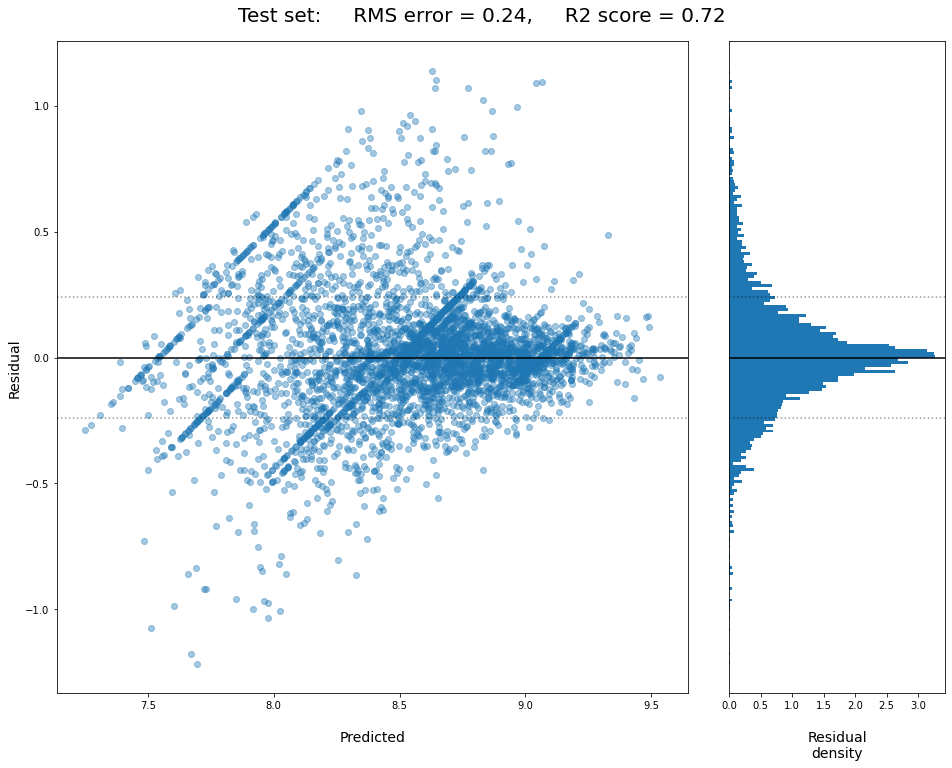

In [7]:
model = keras.models.load_model(BEST_MODEL_FILENAME_FINAL)
y_val_pred = np.squeeze(model.predict(np.expand_dims(X_val, -1)))
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f'For the validation set, mse = {mse:.04f} and r2 = {r2:.04f}')
print(f'That mse corresponds to a standard error of {np.sqrt(mse):.04f}')
y_test_pred = np.squeeze(model.predict(np.expand_dims(X_test, -1)))
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f'\nFor the test set, mse = {mse:.04f} and r2 = {r2:.04f}')
print(f'That mse corresponds to a standard error of {np.sqrt(mse):.04f}\n\n')
residuals('Test set', y_test, y_test_pred)

In [8]:
"""Here are the bins used to stratify the objects by train/val/test in
creating X_train, ..., y_train, ...
"""

strata_bin_edges = [1, 2, 3, 60, np.inf]
model_mean_predict_bins(quasars, model, X_train, y_train, strata_bin_edges,
                        title="Train")
model_mean_predict_bins(quasars, model, X_val, y_val, strata_bin_edges,
                        title="Val")
model_mean_predict_bins(quasars, model, X_test, y_test, strata_bin_edges,
                        title="Test")


   Bin	    N	  MSE	   R2

     1	20259	0.034	0.813
     2	 1170	0.034	0.816
  3-60	  134	0.027	0.851
60-inf	   81	0.007	0.963
   All	21644	0.034	0.814


   Bin	    N	  MSE	   R2

     1	 5788	0.054	0.707
     2	  334	0.052	0.719
  3-60	   39	0.042	0.772
60-inf	   23	0.025	0.865
   All	 6184	0.054	0.709


   Bin	    N	  MSE	   R2

     1	 2894	0.057	0.692
     2	  167	0.043	0.766
  3-60	   19	0.075	0.596
60-inf	   12	0.046	0.754
   All	 3092	0.056	0.695



In [9]:
"""Here is a slightly more detailed set of bins"""

more_detailed_bin_edges = [1, 2, 3, 4, 5, 6, 10, 60, np.inf]
model_mean_predict_bins(quasars, model, X_train, y_train,
                        more_detailed_bin_edges, title="Train")
model_mean_predict_bins(quasars, model, X_val, y_val,
                        more_detailed_bin_edges, title="Val")
model_mean_predict_bins(quasars, model, X_test, y_test,
                        more_detailed_bin_edges,
                        title="Test")


   Bin	    N	  MSE	   R2

     1	20259	0.034	0.813
     2	 1170	0.034	0.816
     3	   81	0.027	0.854
     4	    5	0.064	0.655
     5	    3	0.006	0.967
  6-10	   44	0.026	0.857
 10-60	    1	0.003	0.984
60-inf	   81	0.007	0.963
   All	21644	0.034	0.814


   Bin	    N	  MSE	   R2

     1	 5788	0.054	0.707
     2	  334	0.052	0.719
     3	   23	0.033	0.821
     4	    2	0.001	0.995
     5	    1	0.000	0.999
  6-10	   13	0.068	0.633
 10-60	    0	nan	nan
60-inf	   23	0.025	0.865
   All	 6184	0.054	0.709


   Bin	    N	  MSE	   R2

     1	 2894	0.057	0.692
     2	  167	0.043	0.766
     3	   11	0.104	0.437
     4	    0	nan	nan
     5	    0	nan	nan
  6-10	    8	0.034	0.815
 10-60	    0	nan	nan
60-inf	   12	0.046	0.754
   All	 3092	0.056	0.695

